In [1]:
!pip install mediapipe
import numpy as np
import os
import scipy.io as sio
import cv2
import math
from math import cos, sin
import dlib
import glob
from pathlib import Path
import pandas as pd
from PIL import Image, ImageFilter
import mediapipe as mp
import mediapipe 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Read_Data

In [2]:
mylist = [Path(f).stem for f in glob.glob("/content/AFLW2000/*.jpg")]

In [3]:
def get_list_from_filenames(file_path):
  lines=[Path(f).stem for f in glob.glob(file_path)]
  return lines

**Extract_Points_in_Dlib_train_data**

In [4]:
def get_pt2d_from_mat(mat_path):
    # Get 2D landmarks
    mat = sio.loadmat(mat_path)
    pt2d = mat['pt2d']
    return pt2d

In [5]:
def get_pt3d_68_from_mat(mat_path):
   mat = sio.loadmat(mat_path)
   pt3d = mat['pt3d_68']
   pt3d=pt3d[:2,:]
   X=pt3d.ravel()
   return X


In [6]:
!unzip /content/AFLW2000-3D.zip

Archive:  /content/AFLW2000-3D.zip
replace AFLW2000/Code/DrawSolidHead.m? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


**Extract_poses**

In [7]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

**Data_Class**

In [8]:
class AFLW2000():
    def __init__(self, data_dir,file_path, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.file_path = file_path
        self.img_ext = img_ext
        self.annot_ext = annot_ext

        filename_list = get_list_from_filenames(data_dir)
        filename_list.sort()
        self.X_train = filename_list
        self.y_train = filename_list ####????????????
        self.image_mode = image_mode
        self.length = len(filename_list)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.file_path,self.X_train[index] + self.img_ext))
        img = img.convert(self.image_mode)
        mat_path = os.path.join(self.file_path,self.y_train[index] + self.annot_ext)

        # Crop the face loosely
        pt2d = get_pt2d_from_mat(mat_path)

        x_min = min(pt2d[0,:])
        y_min = min(pt2d[1,:])
        x_max = max(pt2d[0,:])
        y_max = max(pt2d[1,:])

        k = 0.20
        x_min -= 2 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min)
        x_max += 2 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)
        img = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi
        # Bin values
        bins = np.array(range(-99, 102, 3))
        labels =np.digitize([yaw, pitch, roll], bins) - 1
        cont_labels = [yaw, pitch, roll]
          
        #pt_3d_68
        pt_3d=get_pt3d_68_from_mat(mat_path)

        # if self.transform is not None:
        #     img = self.transform(img)
        # return cont_labels
        return img, labels, cont_labels, self.X_train[index],pt_3d

    def __len__(self):
        # 2,000
        return self.length


In [9]:
demo=AFLW2000("/content/AFLW2000/*.mat",'/content/AFLW2000/')

In [10]:
demo.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=628x427 at 0x7F33D218B050>,
 array([33, 25, 34]),
 [1.044306042017331, -22.874238643575588, 4.908885557905314],
 'image00002',
 array([121.868034, 122.36761 , 126.81924 , 130.83179 , 137.52313 ,
        148.52173 , 161.52802 , 182.87668 , 213.94006 , 248.00537 ,
        274.67615 , 293.22473 , 309.20724 , 321.27457 , 329.8783  ,
        339.07126 , 345.24066 , 144.61288 , 158.1359  , 175.37297 ,
        191.31126 , 205.48387 , 261.70496 , 277.2635  , 294.11136 ,
        311.59164 , 323.95364 , 231.0957  , 229.7904  , 227.30476 ,
        225.08842 , 202.42142 , 210.7933  , 222.43806 , 235.00792 ,
        244.54094 , 162.57912 , 173.47615 , 188.50098 , 201.39299 ,
        188.09201 , 172.65819 , 260.8649  , 275.8604  , 291.34073 ,
        301.85168 , 289.989   , 273.8536  , 180.50743 , 192.32265 ,
        209.19904 , 218.46085 , 228.46553 , 248.99286 , 261.81235 ,
        243.97612 , 228.25139 , 212.72568 , 199.55211 , 189.6707  ,
        183.1438  ,

In [11]:
features=[]
labels=[]
imgs=[]
features_68=[]
for i in range(2000):
  labels.append(demo.__getitem__(i)[2])
  features_68.append(demo.__getitem__(i)[4])

## generate features from 2d points

In [12]:
points_features=pd.DataFrame(features_68)



In [13]:

labels_df=pd.DataFrame(labels,columns=['yaw','pitch','roll'])

In [14]:
labels_df.head()

,yaw,pitch,roll
0,1.044306,-22.874239,4.908886
1,68.155241,26.932742,17.243670
2,50.485412,-10.579652,-13.570645
3,17.143374,-10.048456,-21.392783
4,68.640546,-50.544581,-59.207973


In [15]:
data_train=pd.concat([points_features,labels_df],axis=1)

In [16]:
data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,yaw,pitch,roll
0,121.868034,122.367607,126.819237,130.831787,137.523132,148.521729,161.528015,182.876678,213.940063,248.005371,...,310.149048,313.233856,315.107117,322.384613,330.965576,330.701965,324.903870,1.044306,-22.874239,4.908886
1,281.238159,277.339417,274.876953,269.523773,257.788269,240.968155,221.801483,205.846298,207.085449,226.185638,...,303.093811,300.724457,300.060974,303.260895,299.485168,300.598602,302.286499,68.155241,26.932742,17.243670
2,236.385101,239.198257,242.566376,243.971375,242.828186,238.567902,232.561859,229.155289,238.303162,259.122467,...,303.122009,302.877289,302.146454,300.489380,303.481873,304.681732,304.631042,50.485412,-10.579652,-13.570645
3,168.029221,177.697510,190.641602,201.395294,211.957214,222.723099,231.350220,244.332855,268.327637,291.832214,...,315.469391,312.701294,310.133301,300.041290,315.544800,319.498596,320.843994,17.143374,-10.048456,-21.392783
4,280.462250,287.249817,293.892456,297.539368,295.677002,287.270355,271.661591,254.701157,250.219299,261.212463,...,306.811768,307.014893,305.351318,309.934814,311.558899,312.920746,312.058350,68.640546,-50.544581,-59.207973


## Train_Test_split

In [17]:
y=data_train[['yaw','pitch','roll']]
X=data_train.drop(columns=['yaw','pitch','roll'],axis=1)

In [18]:
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
f=scale.fit_transform(X)

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(f,y.values,test_size=0.1,random_state=4,shuffle=True)

## Construct Model

In [21]:
from sklearn.multioutput import MultiOutputClassifier,MultiOutputRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
xgbt=XGBRegressor(n_estimators=300,max_depth=5,objective="reg:squarederror",n_jobs=-1)
multi_target_reg = MultiOutputRegressor(xgbt,n_jobs = -1)
multi_target_reg.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(max_depth=5, n_estimators=300,
                                            n_jobs=-1,
                                            objective='reg:squarederror'),
                     n_jobs=-1)

In [22]:
predictions=multi_target_reg.predict(X_test)

In [23]:
multi_target_reg.score(X_test, y_test, sample_weight=None)

0.8271247668356271

**DLIB dependencies**

In [24]:
from google.colab.patches import cv2_imshow

In [25]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

--2022-06-17 09:53:47--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  89.2MB/s    in 0.7s    

2022-06-17 09:53:48 (89.2 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [26]:
!wget http://arunponnusamy.com/files/mmod_human_face_detector.dat

--2022-06-17 09:53:48--  http://arunponnusamy.com/files/mmod_human_face_detector.dat
Resolving arunponnusamy.com (arunponnusamy.com)... 185.199.111.153, 185.199.108.153, 185.199.110.153, ...
Connecting to arunponnusamy.com (arunponnusamy.com)|185.199.111.153|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.arunponnusamy.com/files/mmod_human_face_detector.dat [following]
--2022-06-17 09:53:48--  https://www.arunponnusamy.com/files/mmod_human_face_detector.dat
Resolving www.arunponnusamy.com (www.arunponnusamy.com)... 185.199.110.153, 185.199.109.153, 185.199.108.153, ...
Connecting to www.arunponnusamy.com (www.arunponnusamy.com)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 729940 (713K) [application/octet-stream]
Saving to: ‘mmod_human_face_detector.dat.1’

mmod_human_face_det 100%[===================>] 712.83K  --.-KB/s    in 0.04s   

2022-06-17 09:53:48 (15.8 MB/s) - ‘mmod_human_face_de

In [27]:
!bzip2 -d  '/content/shape_predictor_68_face_landmarks.dat.bz2'

bzip2: Output file /content/shape_predictor_68_face_landmarks.dat already exists.


In [28]:
predictor=dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')
cnn_face_detector = dlib.get_frontal_face_detector()

## Generate landmarks dlib

**Draw_axis**

In [29]:
def draw_axis(pitch,yaw,roll,img,name=None,path='/content/drive/MyDrive/Head-pose tests/', tdx=None, tdy=None, size = 100):
    faceModule = mediapipe.solutions.face_mesh
    faces = faceModule.FaceMesh(static_image_mode=True)
    if(name!=None):
      img = cv2.imread(path+name+'.jpg')
    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
      results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      tdx = int(results.multi_face_landmarks[0].landmark[6].x * img.shape[1])
      tdy = int(results.multi_face_landmarks[0].landmark[6].y * img.shape[0])

       # height, width = img.shape[:2]
       # tdx = width / 2
       # tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)
    
    return img

In [30]:
def drawPos(path,predictions):
  image = cv2.imread(path)
  cv2_imshow(draw_axis(predictions[0][0],predictions[0][1],predictions[0][2],img=image))
  cv2.destroyAllWindows()

In [31]:
def generate_landmarks(path):
      landmarks_points = []
      landmarks_points_x = []
      landmarks_points_y = []
      if(type(path)==str):
            image=path
            img = cv2.imread( image)
      else:
        img=path 
 
      detector = dlib.get_frontal_face_detector()
      predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')
      # Face 1
      faces = detector(img)
      if faces!= None:
        for face in faces:
            landmarks= predictor(img, face)
            landmarks_points = []
            landmarks_points_x = []
            landmarks_points_y = []
            for n in range(0,68):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                landmarks_points_x.append(x)
                landmarks_points_y.append(y)
        #        cv2.circle(img, (x,y), radius=0, color=(0,0,0), thickness=5)
        #    cv2_imshow(img)
         #   cv2.destroyAllWindows()
        
        return landmarks_points_x+landmarks_points_y
      else:
        return None

In [32]:
landmarks_points=generate_landmarks('/content/Honda2.png')

In [33]:
landmarks_points=np.array(landmarks_points)
landmark_to_model=scale.transform(landmarks_points.reshape(1, -1))

In [34]:
preds=multi_target_reg.predict(landmark_to_model)
preds

array([[ 13.575983, -45.178665,   8.105616]], dtype=float32)

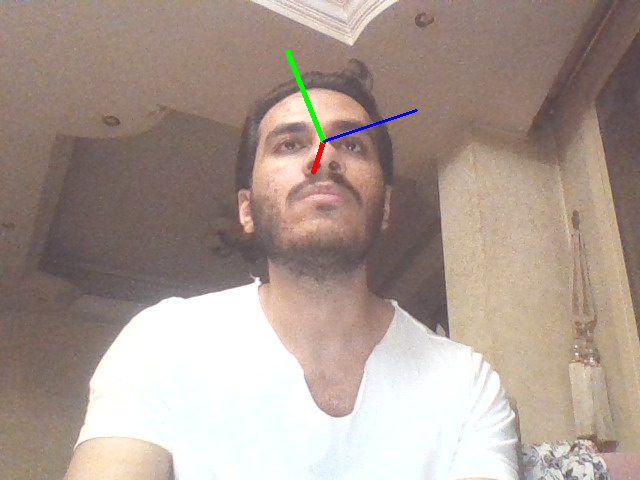

In [35]:
drawPos('/content/Honda2.png',preds)

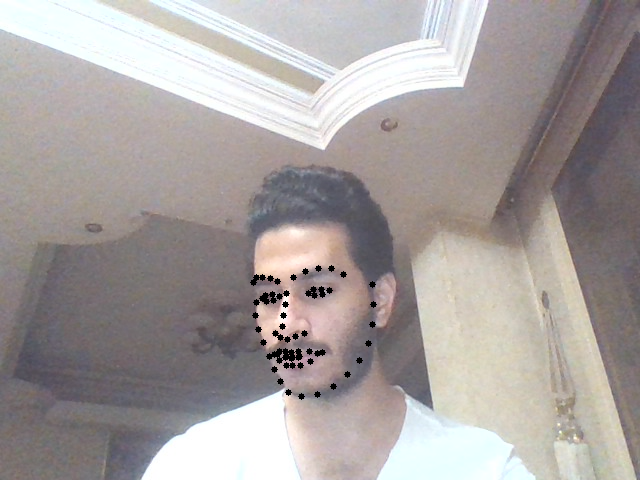

In [43]:
landmarks_points=generate_landmarks('/content/Honda4.png')

In [44]:
landmarks_points=np.array(landmarks_points)
landmark_to_model=scale.transform(landmarks_points.reshape(1, -1))

In [45]:
preds=multi_target_reg.predict(landmark_to_model.reshape(1, -1))

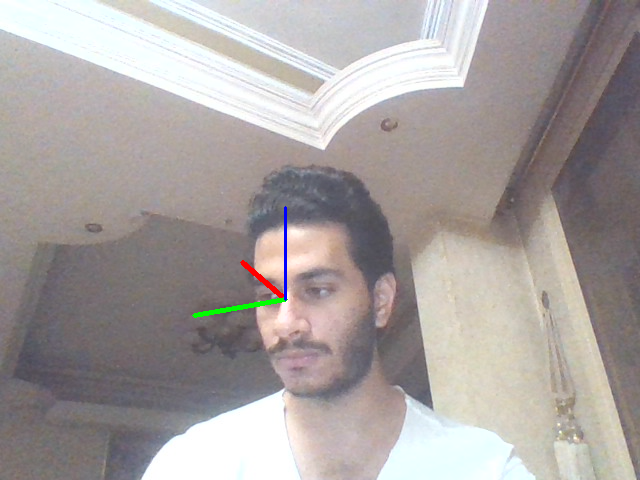

In [46]:
drawPos('/content/Honda4.png',preds)

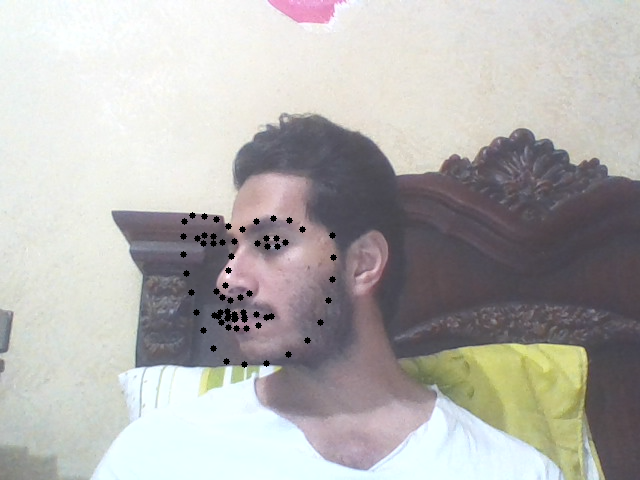

In [48]:
landmarks_points=generate_landmarks('/content/Honda6.png')

In [49]:
landmarks_points=np.array(landmarks_points)
landmark_to_model=scale.transform(landmarks_points.reshape(1, -1))

In [50]:
preds=multi_target_reg.predict(landmark_to_model.reshape(1, -1))
preds

array([[13.706928, -9.039863, -2.673042]], dtype=float32)

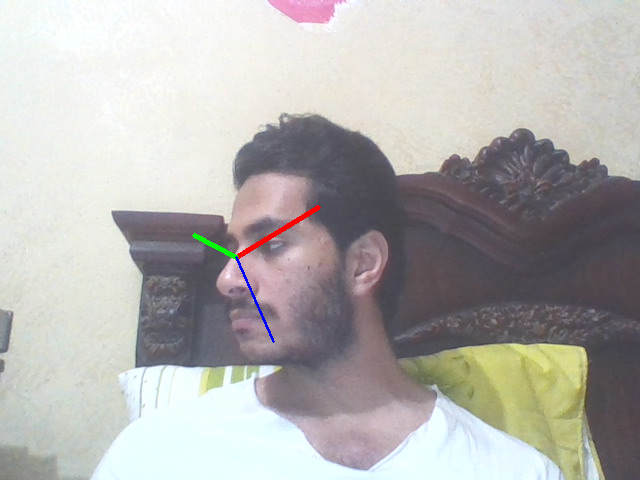

In [51]:
drawPos('/content/Honda6.png',preds)

MediaPipe

In [92]:
import mediapipe
from google.colab.patches import cv2_imshow
import cv2

In [93]:
import mediapipe as mp

In [94]:
mp_faceModule = mp.solutions.face_mesh
# Load drawing_utils and drawing_styles
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles


**Draw Axis**

**LandMarks**

In [95]:
def generate_landmarks_mediapipe(name,img,path=None):
  # choosing random image
  random_file = name
  X=[]
  Y=[]

  faceModule = mediapipe.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      if(path!=None) :
        image = cv2.imread(path+random_file+'.jpg')
      else :  image = img
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                X.append(x)
                Y.append(y)
      return(X,Y)

**Points**

In [96]:
def drawPoints_media(name,path='/content/AFLW2000/'):
  # choosing random image
  random_file = name

  faceModule = mediapipe.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      image = cv2.imread(path+random_file+'.jpg')
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
        cv2_imshow(image)

**Axis**

In [97]:
def draw_axis(pitch,yaw,roll,img,name=None,path='/content/drive/MyDrive/Head-pose tests/', tdx=None, tdy=None, size = 100):
    faceModule = mediapipe.solutions.face_mesh
    faces = faceModule.FaceMesh(static_image_mode=True)
    if(name!=None):
      img = cv2.imread(path+name+'.jpg')
    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
      results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      tdx = int(results.multi_face_landmarks[0].landmark[6].x * img.shape[1])
      tdy = int(results.multi_face_landmarks[0].landmark[6].y * img.shape[0])

       # height, width = img.shape[:2]
       # tdx = width / 2
       # tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)
    
    return img

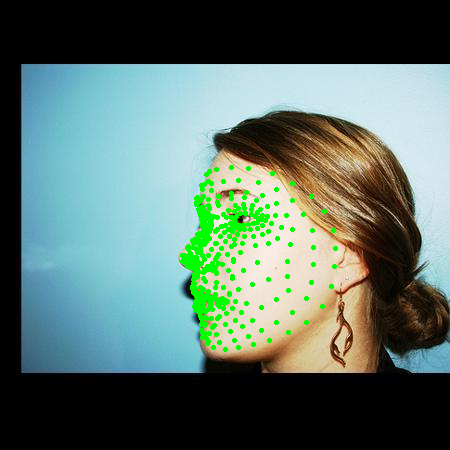

In [98]:
drawPoints_media('image00022')

In [99]:
def drawPos_media(name,customPose=None,path='/content/AFLW2000/'):
  random_file = name
  image = cv2.imread(path+random_file+'.jpg')
  # loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
  # extracting the labels 3 angels
  if (customPose!=None) : pose_para=customPose
  else : 
    mat_file = sio.loadmat(path+random_file+'.mat')
    pose_para = mat_file["Pose_Para"][0][:3]
  pitch = pose_para[0]
  yaw = pose_para[1]
  roll = pose_para[2]
  cv2_imshow(draw_axis(pitch,yaw,roll,img=image))

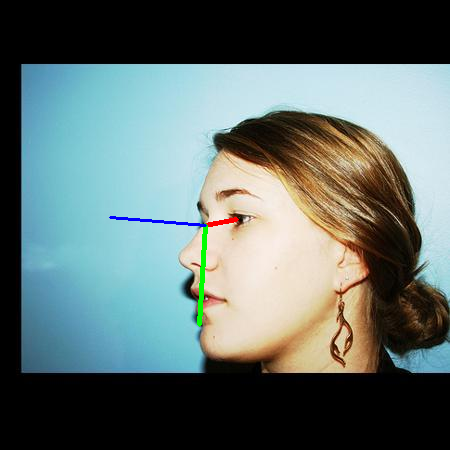

In [100]:
drawPos_media('image00022')

In [101]:
demo=AFLW2000("/content/AFLW2000/*.mat",'/content/AFLW2000/')

In [102]:
labels=[]
imgs=[]
for i in range(demo.length):
  pla=demo.__getitem__(i)
  x = np.array(pla[1], dtype=np.float32)
  labels.append(x)
  imgs.append(pla[3])

In [103]:
df = pd.DataFrame(labels,columns=['yaw', 'pitch', 'roll'],index=imgs) #convert to a dataframe
df

,yaw,pitch,roll
image00002,33.0,25.0,34.0
image00004,55.0,41.0,38.0
image00006,49.0,29.0,28.0
image00008,38.0,29.0,25.0
image00010,55.0,16.0,13.0
...,...,...,...
image04358,31.0,29.0,35.0
image04363,5.0,28.0,36.0
image04364,60.0,5.0,4.0
image04365,10.0,24.0,41.0


In [124]:
filenames = get_list_from_filenames('/content/AFLW2000/*.mat')
filenames.sort()

In [125]:
landmarksX = []
landmarksY = []
for i in filenames :
  landmarks = generate_landmarks_mediapipe(i,None,path='/content/AFLW2000/')
  #print(sum(landmarks[0]),sum(landmarks[1]))
  landmarksX.append(landmarks[0])
  landmarksY.append(landmarks[1])
  # np.append(landmarksX,landmarks[0])
  # np.append(landmarksY,landmarks[1])

In [126]:
X = pd.DataFrame(landmarksX,columns=["x"+str(i) for i in range(1,469)],index=filenames)
Y = pd.DataFrame(landmarksY,columns=["y"+str(i) for i in range(1,469)],index=filenames)

In [127]:
data = pd.concat([X,Y,df],axis=1)

In [128]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y462,y463,y464,y465,y466,y467,y468,yaw,pitch,roll
image00002,0.485651,0.489194,0.489802,0.479730,0.490558,0.493633,0.503193,0.363678,0.508629,0.510569,...,0.644283,0.644457,0.485137,0.492813,0.500371,0.471336,0.464005,33.0,25.0,34.0
image00004,0.441502,0.417273,0.448839,0.435994,0.415757,0.426780,0.464200,0.464412,0.474128,0.472069,...,0.600357,0.604871,0.506956,0.511724,0.514913,0.500244,0.495387,55.0,41.0,38.0
image00006,0.317797,0.321328,0.318316,0.311064,0.321459,0.320353,0.316353,0.247193,0.314674,0.314501,...,0.778855,0.779742,0.717794,0.720868,0.723342,0.713071,0.709798,49.0,29.0,28.0
image00008,0.503922,0.469521,0.489504,0.444433,0.461756,0.457114,0.451360,0.361577,0.437648,0.428051,...,0.651913,0.652300,0.500958,0.510606,0.518652,0.455611,0.444623,38.0,29.0,25.0
image00010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,16.0,13.0


In [129]:
data.dropna(inplace=True)

In [130]:
X_train = data.iloc[:, :-3]
y_train = data.iloc[:, -3:]

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train , test_size=0.20, random_state=42)

In [132]:
from sklearn.multioutput import MultiOutputClassifier,MultiOutputRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


xgbt=XGBRegressor(n_estimators=300,max_depth=5,objective="reg:squarederror",n_jobs=-1)
multi_target_reg_media = MultiOutputRegressor(xgbt,n_jobs = -1)
multi_target_reg_media.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(max_depth=5, n_estimators=300,
                                            n_jobs=-1,
                                            objective='reg:squarederror'),
                     n_jobs=-1)

In [133]:
predictions_media_xgb=multi_target_reg_media.predict(X_test)

In [134]:
multi_target_reg_media.score(X_test, y_test, sample_weight=None)

0.7475284265157472

In [135]:
def test_new_photo(imgnm):
  if os.path.isfile('/content/AFLW2000/'+name+'.jpg') == False:
    print('x')
  landmarks = generate_landmarks_mediapipe(name,None,path='/content/AFLW2000/')
  #print(sum(landmarks[0]),sum(landmarks[1]))
  landmark_X= []
  landmark_Y= []
  landmark_X.append(landmarks[0])
  landmark_Y.append(landmarks[1])
  drawPoints_media(imgnm,path='/content/AFLW2000/')
  X = pd.DataFrame(landmarksX,columns=["x"+str(i) for i in range(1,469)])
  Y = pd.DataFrame(landmarksY,columns=["y"+str(i) for i in range(1,469)])
  to_pred = pd.concat([X,Y],axis=1)
  preds=multi_target_reg_media.predict(to_pred)
  img = draw_axis(preds[0].tolist()[0],preds[0].tolist()[1],preds[0].tolist()[2],None,name=imgnm,path='/content/AFLW2000/', tdx=None, tdy=None, size = 100)
  cv2_imshow(img)

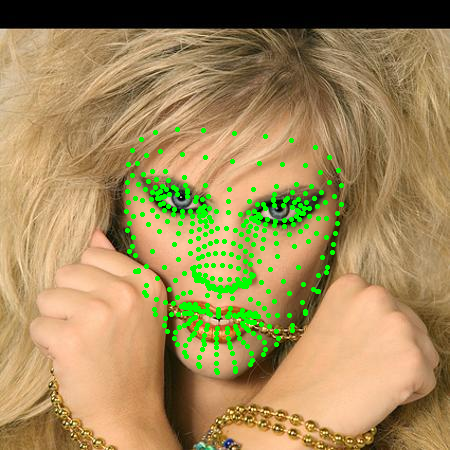

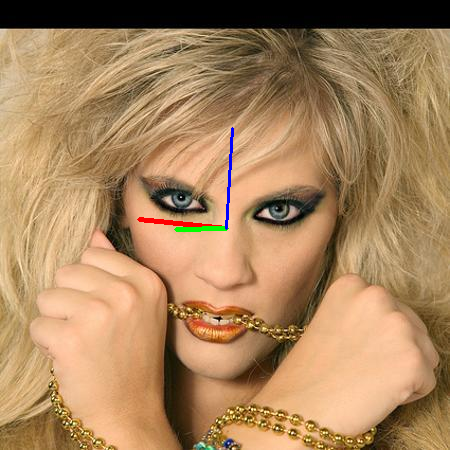

In [136]:
name = 'image00002'
test_new_photo(name)

**vedio test mediapipe**

In [141]:
cap = cv2.VideoCapture('/content/drive/MyDrive/pose_est/honda.mp4')

if (cap.isOpened()== False): 
  print("Error opening video  file")

#see number of frames
int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

494

In [142]:
frames=[]
success,image = cap.read()
count = 0
landmarksX = []
landmarksY = []
while success:
  #cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = cap.read()
  if(success):
    landmarks = generate_landmarks_mediapipe(None,image)
    if(landmarks[0] == [] or landmarks[1] == []):
       continue
    landmarksX.append(landmarks[0])
    landmarksY.append(landmarks[1])
    frames.append(image)
    count += 1

In [139]:
X = pd.DataFrame(landmarksX,columns=["x"+str(i) for i in range(1,469)])
Y = pd.DataFrame(landmarksY,columns=["y"+str(i) for i in range(1,469)])
to_pred =pd.concat([X,Y],axis=1)
print(to_pred.isna().sum())
print(len(to_pred))
print(count)


x1      0
x2      0
x3      0
x4      0
x5      0
       ..
y464    0
y465    0
y466    0
y467    0
y468    0
Length: 936, dtype: int64
410
410


In [140]:
preds = multi_target_reg_media.predict(to_pred)
preds.shape

(410, 3)

In [85]:
frames_out = []
for i in range(0,preds.shape[0],3):
  img = draw_axis(preds[i].tolist()[0],preds[i].tolist()[1],preds[i].tolist()[2],frames[i])
  frames_out.append(img)
  #cv2_imshow(img)

In [86]:
print(len(frames_out))
w, h = frames[0].shape[0],frames[0].shape[1]
writer = cv2.VideoWriter('honda(3).mp4', cv2.VideoWriter_fourcc(*'DIVX'), 15, (h,w))
for frame in frames_out:
  writer.write(frame)
writer.release()

137
